In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import math
import pandas as pd
import glob
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.utils.slope_and_trend import _slope
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sktime.datatypes._panel._convert import from_nested_to_2d_array

In [2]:
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

# Function turning .csv's into dataframe

In [3]:
def combine_csvs(path_var, path_mulens):
    """ 
    
    This function takes in csv fils of variable star and microlensing data, combines the two files into 1 dataframe,
    and appends the appropriate light curve data with the classification labels:
    1: Microlensing Event
    0: Variable star Event.
    
    Returns:
    Dataframe of data (X) and classificaton labels (y)
    
    """
    df = []
    y=0
    for filepath in glob.glob(path_var + '*.csv'):
        ts = pd.read_csv(filepath, delimiter=',', header=None)
        ts_ = [ts, y]
        df.append(ts_)
    
    y=1
    gloob = glob.glob(path_mulens + '*.csv')
    for i in np.arange(0, 1250, 2):
        filepath = gloob[i]
        ts = pd.read_csv(filepath, delimiter=',', header=None)
        ts_ = [ts, y]
        df.append(ts_)

    df = pd.DataFrame(df, columns=('X', 'y'))
    df = df.reset_index()
    
    for i in range(len(df['X'])):
        if len(df['X'][i]) < 1000:
            df['X'][i].append(df['X'].iloc[-1])
        elif len(df['X'][i]) > 1000:
            df['X'][i] = df['X'][i][:-1]
    
    col_names = []
    for i in range(len(df['X'][0])):
        col_names.append('X_' + str(i))
        
    X = []

    for i in range(len(df['X'])):
        X.append(np.asarray(df['X'][i]))

    X = np.reshape(X, (1064,1000))
    data = pd.DataFrame(X)

    y = np.array(df['y'])
    
    data['y'] = y
    
    data = data.dropna(axis=0)
    
    X = data.iloc[::, 0:1000]
    
    y = data.iloc[::,1000]
    
    return(X, y)

# Function for Machine Learning Algorithms:

Iterates through: 

RandomForestClassifier, 
Stochastic Gradient Descent, 
Decision Tree, 
Support Vector Machine, 
Gaussian Naive Bayes.

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

In [27]:
def ml_comparison(X, y, train_size, iterations):
    """
    
    Inputs:
    X: Data 
    y: Classification labels
    train_size: Percentage of data used for training (parameter used for sklearn.model_selection.train_test_split())
    iterations: Integer number of iterations through each machine learning algorithm
    
    Returns:
    Bar Chart and table showing false positives, false negatives, and accuracy of each ML algorithm
    
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, shuffle=True)
    

    """Random Forest Classifier"""
    acc_array = np.zeros(iterations)
    fp_array = np.zeros(iterations)
    fn_array = np.zeros(iterations)
    
    
    rf_false_class = []
    i = 0
    print("Random Forest Classifier starting...")
    for i in range(iterations):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        classifier = RandomForestClassifier(n_estimators=100)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        for j in range(len(y_test)):
            if y_test.iloc[j] != y_pred[j]:
                false_class_arr = [y_test.index[j], y_test.iloc[j]]
                rf_false_class.append(false_class_arr)
        #acc = accuracy_score(y_test, y_pred)
        acc_train = accuracy_score(y_train, classifier.predict(X_train)) # Add to each algorithm
        #print("Accuracy for iteration %s: " % (i) + str(acc))
        confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        acc_array[i] = acc_train
        fp_array[i] = fp
        fn_array[i] = fn
        i += 1
    rf_fails = [np.mean(fp_array), np.mean(fn_array), np.mean(acc_array)]    
    print("Random Forest Classifier completed.")
    
    """ Stochastic Gradient Descent"""
    
    acc_array = np.zeros(iterations)
    fp_array = np.zeros(iterations)
    fn_array = np.zeros(iterations)
    
    sg_false_class = []
    i = 0
    print("Stochastic Gradient Descent starting...")
    for i in range(iterations):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        clf.fit(X_train, y_train)
        Pipeline(steps=[('standardscaler', StandardScaler()),
                        ('sgdclassifier', SGDClassifier())])
        y_pred = clf.predict(X_test)
        for j in range(len(y_test)):
            if y_test.iloc[j] != y_pred[j]:
                false_class_arr = [y_test.index[j], y_test.iloc[j]]
                sg_false_class.append(false_class_arr)
        #acc = accuracy_score(y_test, y_pred)
        acc_train = accuracy_score(y_train, clf.predict(X_train))
        #print("Accuracy for iteration %s: " % (i) + str(acc))
        confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        acc_array[i] = acc_train
        fp_array[i] = fp
        fn_array[i] = fn
        i += 1

    sgd_fails = [np.mean(fp_array), np.mean(fn_array), np.mean(acc_array)]
    print("Stochastic Gradient Descent completed.")
    
    """ Decision Tree """
    
    acc_array = np.zeros(iterations)
    fp_array = np.zeros(iterations)
    fn_array = np.zeros(iterations)
    
    dt_false_class = []
    i = 0
    print("Decision Tree starting...")
    for i in range(iterations):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        clf = tree.DecisionTreeClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        for j in range(len(y_test)):
            if y_test.iloc[j] != y_pred[j]:
                false_class_arr = [y_test.index[j], y_test.iloc[j]]
                dt_false_class.append(false_class_arr)
        #acc = accuracy_score(y_test, y_pred)
        acc_train = accuracy_score(y_train, clf.predict(X_train))
        #print("Accuracy for iteration %s: " % (i) + str(acc))
        confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        acc_array[i] = acc_train
        fp_array[i] = fp
        fn_array[i] = fn
        i += 1

    dt_fails = [np.mean(fp_array), np.mean(fn_array), np.mean(acc_array)]
    print("Decision Tree completed.")
    
    """ Support Vector Machine """
    
    acc_array = np.zeros(iterations)
    fp_array = np.zeros(iterations)
    fn_array = np.zeros(iterations)

    svm_false_class = []
    i = 0
    print("Support Vector Machine starting...")
    for i in range(iterations):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        for j in range(len(y_test)):
            if y_test.iloc[j] != y_pred[j]:
                false_class_arr = [y_test.index[j], y_test.iloc[j]]
                svm_false_class.append(false_class_arr)
        #acc = accuracy_score(y_test, y_pred)
        acc_train = accuracy_score(y_train, clf.predict(X_train))
        #print("Accuracy for iteration %s: " % (i) + str(acc))
        confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        acc_array[i] = acc_train
        fp_array[i] = fp
        fn_array[i] = fn
        i += 1

    svm_fails = [np.mean(fp_array), np.mean(fn_array), np.mean(acc_array)]
    print("Support Vector Machine completed.")
    
    """ Gaussian Naive Bayes """
    acc_array = np.zeros(iterations)
    fp_array = np.zeros(iterations)
    fn_array = np.zeros(iterations)

    gnb_false_class = []
    i = 0
    print("Gaussian Naive Bayes starting...")
    for i in range(iterations):
        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        gnb = GaussianNB()
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        for j in range(len(y_test)):
            if y_test.iloc[j] != y_pred[j]:
                false_class_arr = [y_test.index[j], y_test.iloc[j]]
                gnb_false_class.append(false_class_arr)
        #acc = accuracy_score(y_test, y_pred)
        acc_train = accuracy_score(y_train, gnb.fit(X_train,y_train).predict(X_train))
        #print("Accuracy for iteration %s: " % (i) + str(acc))
        confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        acc_array[i] = acc_train
        fp_array[i] = fp
        fn_array[i] = fn
        i += 1

    gnb_fails = [np.mean(fp_array), np.mean(fn_array), np.mean(acc_array)]
    print("Gaussian Naive Bayes completed.")
    
    false_pos = [rf_fails[0], sgd_fails[0], gnb_fails[0], dt_fails[0], svm_fails[0]]
    false_neg = [rf_fails[1], sgd_fails[1], gnb_fails[1], dt_fails[1], svm_fails[1]]
    acc = [rf_fails[2], sgd_fails[2], gnb_fails[2], dt_fails[2], svm_fails[2]]

    false_pos = np.round_(false_pos, decimals=2)
    false_neg = np.round_(false_neg, decimals=2)
    acc = np.round_(acc, decimals=2)
    data = [false_pos, false_neg, acc]
    
    false_class = [rf_false_class, sg_false_class, dt_false_class, svm_false_class, gnb_false_class]
    
    return(data, false_pos, false_neg, acc, false_class)

# Bar Plot and Table Function

In [6]:
""" Bar Plot and Table """
def bar_plot_make(data, false_pos, false_neg, acc, data_prev, save_fig):    
    # fails=[false_pos, false_neg, acc]
    
    data = np.asarray(data)

    if data_prev!=False:
        
        data_change = np.zeros(data.shape)
        data_ = np.zeros(data.shape).astype(str)
        
        for i in range(len(data_change)):
            for j in range(len(data_change[i])):
                data_change[i][j] = ((data[i][j] - data_prev[i][j]) / data_prev[i][j]) * 100
                
        data = data.astype(str)
        data_change = np.round_(data_change, decimals=2)
        data_change = np.array(data_change).astype(str)
        
        for i in range(len(data_)):
            for j in range(len(data_[i])):
                data_[i][j] = str(data[i][j] + '\n' + '(%s%%)' % (data_change[i][j]))


    else:
        data_ = np.round_(data, decimals=2)
    
    #data_ = np.round_(data_, decimals=2)
    labels = ['Random \n Forest', 'SGD', 'Gaussian \n NB', 'Decision \n Tree', 'SVM']
    
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    #ax2 = ax.twinx()
    ax.zorder = 2
    #ax2.zorder = 2

    rects1 = ax.bar(x - width/2, false_pos, width, label='False Positive')
    rects2 = ax.bar(x + width/2, false_neg, width, label='False Negative')
    #rects3 = ax2.bar(x, acc, width*2, label='Accuracy', alpha = 0.1, color='green')

    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Average')
    ax.set_ylim(0, 85)
    ax.set_title('Classifier Comparison for 1,000 Iterations')
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(labels)
    
    #ax.set_xticklabels(labels, rotation=45)
    ax.legend(loc='upper right', markerscale=0.02, markerfirst=False, fontsize='small')

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)
    #ax2.bar_label(rects3, padding=3)

    color = 'tab:blue'
    #ax2.set_ylabel('Accuracy', color='green')  # we already handled the x-label with ax1
    #ax2.bar(x - width/2, acc, color=color)
    #ax2.tick_params(axis='y', labelcolor='green')


    fig.tight_layout(rect=(0,0,1,1.6))
    if save_fig==True:
        plt.savefig('/mnt/c/users/user/Desktop/ThesisFigures/ClassifierComparisonHist.png', format='png', bbox_inches='tight')
    plt.show()
    
    
    # Table makin business
    fig2, ax2 = plt.subplots()
    #rcolors = plt.cm.BuPu(np.full(3), 0.1)
    #ccolors = plt.cm.BuPu(np.full(5), 0.1)
    
    the_table = ax2.table(cellText=data_,
          rowLabels=['\n False \n Positives \n', '\n False \n Negatives \n', ' \n Accuracy \n'],                
          colLabels=labels,
          cellLoc='center',
          loc='center',
          fontsize=20,
          rowLoc='center')
    for (row, col), cell in the_table.get_celld().items():
        if(row==0) or (col==-1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
                          
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(11)
    the_table.scale(1.5,3)
    ax2.axis('off')
    if save_fig==True:
        plt.savefig('/mnt/c/users/user/Desktop/ThesisFigures/ClassifierComparisonTable.png', format='png', bbox_inches='tight')
    plt.show()
    

# Clean Light Curves:

#### Variable Curves: Savgol Filter.
#### Microlensing Curves: Clean, No Noise

In [25]:
path_var = '/mnt/c/users/user/Desktop/norm_savgol_filter_lc/'
path_mulens = '/mnt/c/users/user/Desktop/norm_mulens_no_noise_data2/'

X, y = combine_csvs(path_var, path_mulens)

<ipython-input-3-4930af522090>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['X'][i] = df['X'][i][:-1]


In [8]:
y.value_counts()[0]
#X.sample(n=len(y))
#XX = X.sample(n=y.value_counts()[0])
#print(len(XX))

436

In [9]:
y.value_counts()[1]

625

In [13]:
print(X.shape)

(1061, 1000)


In [28]:
path_var = '/mnt/c/users/user/Desktop/norm_savgol_filter_lc/'
path_mulens = '/mnt/c/users/user/Desktop/norm_mulens_no_noise_data2/'

X, y = combine_csvs(path_var, path_mulens)


nn_data, nn_false_pos, nn_false_neg, nn_acc, false_class = ml_comparison(X, y, train_size=0.8, iterations=1000)


<ipython-input-3-4930af522090>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['X'][i] = df['X'][i][:-1]


Random Forest Classifier starting...
Random Forest Classifier completed.
Stochastic Gradient Descent starting...
Stochastic Gradient Descent completed.
Decision Tree starting...
Decision Tree completed.
Support Vector Machine starting...
Support Vector Machine completed.
Gaussian Naive Bayes starting...
Gaussian Naive Bayes completed.


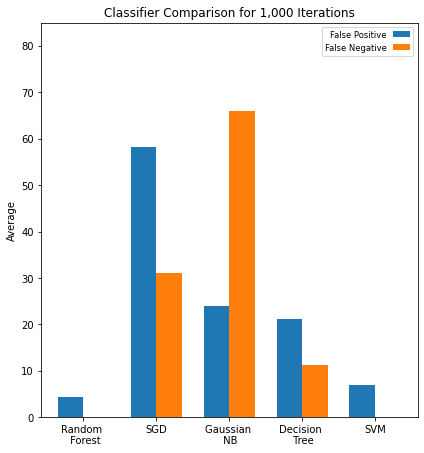

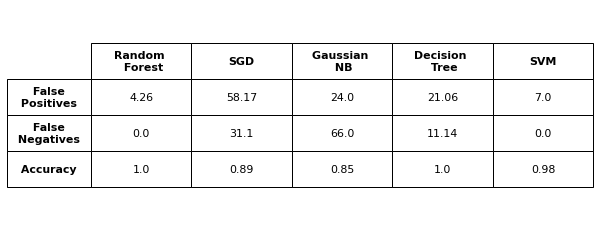

In [29]:
bar_plot_make(nn_data, nn_false_pos, nn_false_neg, nn_acc, data_prev=False, save_fig=False)
#table_make(nn_data, nn_false_pos, nn_false_neg, nn_acc, data_prev=False)

# Moderate Noise

#### Variable and Microlensing Curves: Half of M.T. Penny Noise Curve Value

In [107]:
path_var = '/mnt/c/users/user/Desktop/moderate_noise_var_normed_trimmed/'
path_mulens = '/mnt/c/users/user/Desktop/moderate_noise_mulens_normed/'

X, y = combine_csvs(path_var, path_mulens)

mn_data, mn_false_pos, mn_false_neg, mn_acc, false_class_mn = ml_comparison(X, y, train_size=0.5, iterations=5)


<ipython-input-3-4930af522090>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['X'][i] = df['X'][i][:-1]


Random Forest Classifier starting...
Random Forest Classifier completed.
Stochastic Gradient Descent starting...
Stochastic Gradient Descent completed.
Decision Tree starting...
Decision Tree completed.
Support Vector Machine starting...
Support Vector Machine completed.
Gaussian Naive Bayes starting...
Gaussian Naive Bayes completed.


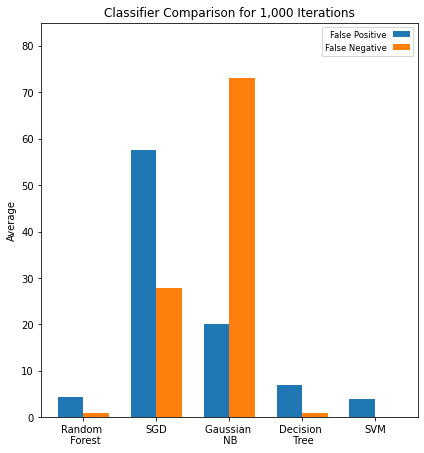

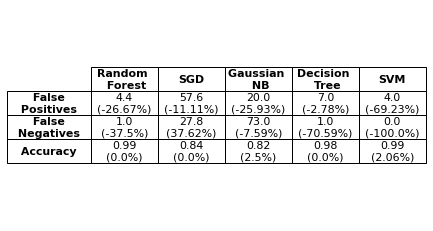

In [108]:
bar_plot_make(mn_data, mn_false_pos, mn_false_neg, mn_acc, data_prev=nn_data)

# Full Noise

#### Full variable and Full M.T Penny microlensing noise curves.

In [30]:
path_var = '/mnt/c/users/user/Desktop/full_noise_var_normed_trimmed/'
path_mulens = '/mnt/c/users/user/Desktop/full_noise_mulens_normed_current2/'

X, y = combine_csvs(path_var, path_mulens)

fn_data, fn_false_pos, fn_false_neg, fn_acc, false_class_fn = ml_comparison(X, y, train_size=0.9, iterations=1000)


<ipython-input-3-4930af522090>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['X'][i] = df['X'][i][:-1]


Random Forest Classifier starting...
Random Forest Classifier completed.
Stochastic Gradient Descent starting...
Stochastic Gradient Descent completed.
Decision Tree starting...
Decision Tree completed.
Support Vector Machine starting...
Support Vector Machine completed.
Gaussian Naive Bayes starting...
Gaussian Naive Bayes completed.


<ipython-input-6-3bc3fbebc353>:14: RuntimeWarning: divide by zero encountered in double_scalars
  data_change[i][j] = ((data[i][j] - data_prev[i][j]) / data_prev[i][j]) * 100
<ipython-input-6-3bc3fbebc353>:14: RuntimeWarning: invalid value encountered in double_scalars
  data_change[i][j] = ((data[i][j] - data_prev[i][j]) / data_prev[i][j]) * 100


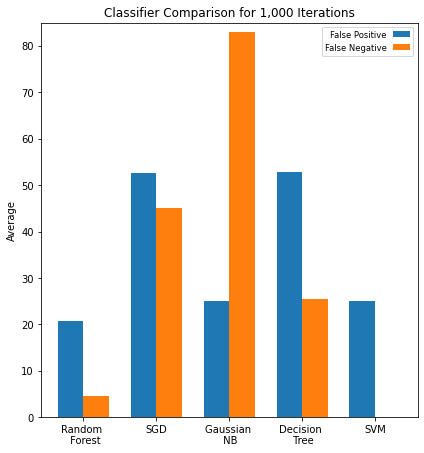

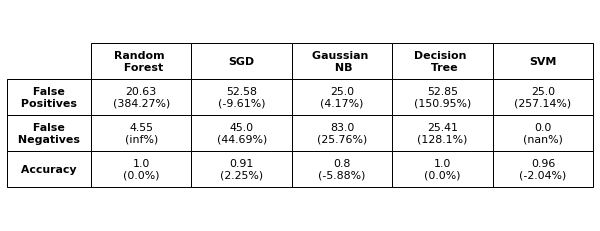

In [31]:
bar_plot_make(fn_data, fn_false_pos, fn_false_neg, fn_acc, data_prev=nn_data, save_fig=False)

In [54]:
from collections import Counter

In [80]:
false_class_fn[1][0]

[182, 0]

In [77]:
Counter(false_class_fn[0][0])

Counter({290: 1, 0: 1})

In [81]:
counts = Counter()
for i in range(len(false_class_fn)):
    for j in range(len(false_class_fn[i])):
        counts += Counter(false_class_fn[i][j])

In [82]:
counts

Counter({290: 7,
         0: 1074,
         124: 13,
         1009: 8,
         1: 777,
         811: 20,
         96: 25,
         49: 25,
         765: 18,
         319: 14,
         268: 25,
         186: 25,
         151: 15,
         766: 15,
         141: 25,
         572: 24,
         458: 8,
         222: 25,
         56: 25,
         320: 25,
         252: 25,
         50: 22,
         219: 12,
         281: 25,
         265: 17,
         188: 25,
         367: 9,
         517: 16,
         26: 11,
         128: 20,
         196: 15,
         719: 13,
         52: 12,
         376: 25,
         267: 22,
         83: 23,
         228: 21,
         326: 15,
         203: 14,
         178: 25,
         908: 19,
         125: 11,
         255: 25,
         84: 11,
         140: 25,
         264: 9,
         984: 18,
         149: 7,
         229: 18,
         54: 7,
         420: 12,
         932: 6,
         361: 5,
         226: 10,
         182: 5,
         449: 10,
         71

In [121]:
cols = ['Number']
_counts = pd.DataFrame.from_dict(counts, orient='Index', columns = cols)
_counts.reset_index(inplace=True)
_counts.sort_values(by='index')
_counts = _counts[_counts['index']>1]
_counts = _counts.sort_values(by='Number', ascending=False)

In [122]:
_counts

,index,Number
42,255,25
14,141,25
33,376,25
44,140,25
25,188,25
23,281,25
20,252,25
19,320,25
18,56,25
17,222,25


In [117]:
X[0]

0       0.000910
1       0.033476
2       0.121965
3       0.660468
4       0.751668
5       0.546996
6       0.562970
7       0.360848
8       0.422812
9       0.426053
10      0.500985
11      0.502517
12      0.376425
13      0.873025
14      0.541193
15      0.695599
16      0.221157
17      0.201878
18      0.993454
19      0.436117
20      0.460325
21      0.643433
22      0.678087
23      0.507746
24      0.076397
25      0.546709
26      0.748447
27      0.093282
28      0.032757
29      0.132965
30      0.237240
31      0.110555
32      0.501131
33      0.177422
34      0.114939
35      0.594795
36      0.783393
37      0.352841
38      0.132388
39      0.099156
40      1.000000
41      0.351983
42      0.645368
43      0.892460
44      0.574616
45      0.058208
46      0.119991
47      0.927744
48      0.518681
49      0.905102
50      0.880099
51      0.217812
52      0.877539
53      0.826428
54      0.662231
55      0.494345
56      0.777729
57      0.063001
58      0.5573

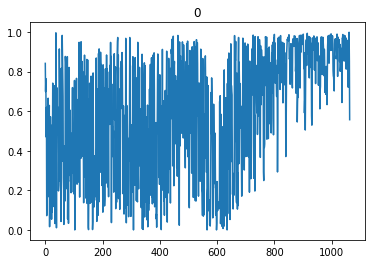

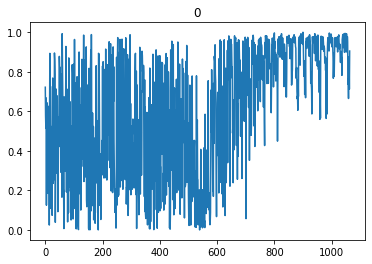

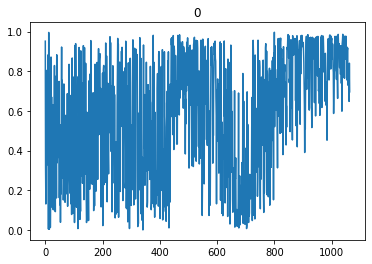

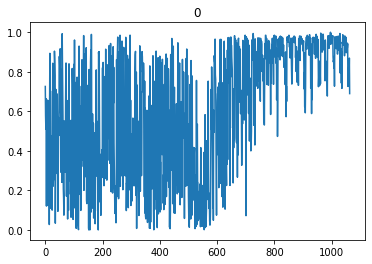

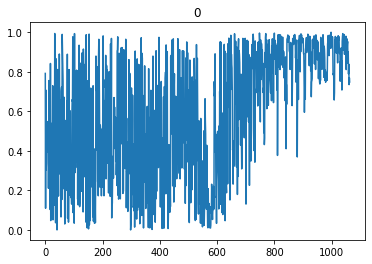

In [127]:
for i in range(5):
    plt.plot(X[_counts['index'].iloc[i]])
    plt.title('%s' % (y[_counts['index'].iloc[i]]))
    plt.show()
    

In [131]:
fn_acc

array([0.92, 0.8 , 0.81, 0.84, 0.94])

In [134]:
np.arange(0.1, 1.0, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Random Forest Classifier starting...
Random Forest Classifier completed.
Stochastic Gradient Descent starting...
Stochastic Gradient Descent completed.
Decision Tree starting...
Decision Tree completed.
Support Vector Machine starting...
Support Vector Machine completed.
Gaussian Naive Bayes starting...
Gaussian Naive Bayes completed.
Random Forest Classifier starting...
Random Forest Classifier completed.
Stochastic Gradient Descent starting...
Stochastic Gradient Descent completed.
Decision Tree starting...
Decision Tree completed.
Support Vector Machine starting...
Support Vector Machine completed.
Gaussian Naive Bayes starting...
Gaussian Naive Bayes completed.
Random Forest Classifier starting...
Random Forest Classifier completed.
Stochastic Gradient Descent starting...
Stochastic Gradient Descent completed.
Decision Tree starting...
Decision Tree completed.
Support Vector Machine starting...
Support Vector Machine completed.
Gaussian Naive Bayes starting...
Gaussian Naive Bayes 

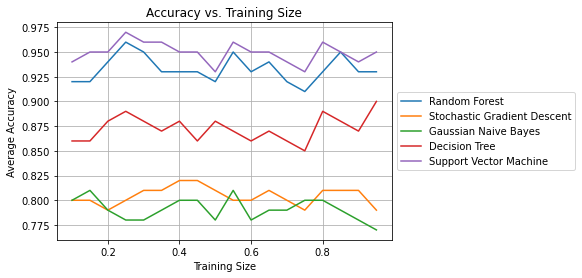

In [146]:

accs = np.arange(0.1, 1.0, 0.05)
rf_accs = np.zeros(len(accs))
sgd_accs = np.zeros(len(accs))
gnb_accs = np.zeros(len(accs))
dt_accs = np.zeros(len(accs))
svm_accs = np.zeros(len(accs))

for i in range(len(accs)):
    fn_data, fn_false_pos, fn_false_neg, fn_acc, false_class_fn = ml_comparison(X, y, train_size=accs[i], iterations=1000)
    rf_accs[i] = fn_acc[0]
    sgd_accs[i] = fn_acc[1]
    gnb_accs[i] = fn_acc[2]
    dt_accs[i] = fn_acc[3]
    svm_accs[i] = fn_acc[4]

plt.plot(accs, rf_accs, label='Random Forest')
plt.plot(accs, sgd_accs, label='Stochastic Gradient Descent')
plt.plot(accs, gnb_accs, label='Gaussian Naive Bayes')
plt.plot(accs, dt_accs, label='Decision Tree')
plt.plot(accs, svm_accs, label='Support Vector Machine')
plt.xlabel('Training Size')
plt.ylabel('Average Accuracy')
plt.title('Accuracy vs. Training Size')
plt.subplot(111).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

In [148]:
counts = Counter()
for i in range(len(false_class_fn)):
    for j in range(len(false_class_fn[i])):
        counts += Counter(false_class_fn[i][j])
        
cols = ['Number']
_counts = pd.DataFrame.from_dict(counts, orient='Index', columns = cols)
_counts.reset_index(inplace=True)
_counts.sort_values(by='index')
_counts = _counts[_counts['index']>1]
_counts = _counts.sort_values(by='Number', ascending=False)
_counts

,index,Number
12,258,5000
26,56,5000
28,376,5000
18,314,5000
8,49,5000
46,320,4993
45,253,4973
32,252,4943
13,811,4768
20,95,4622


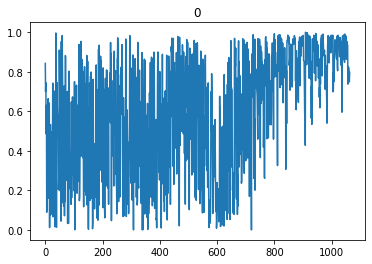

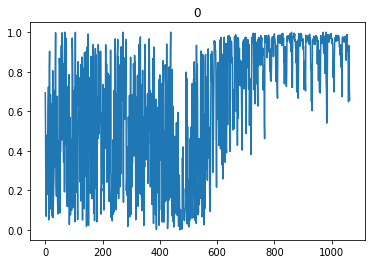

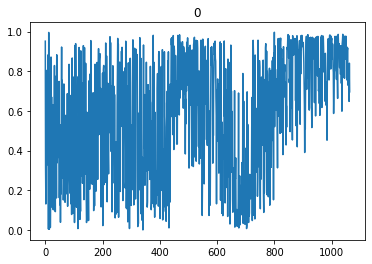

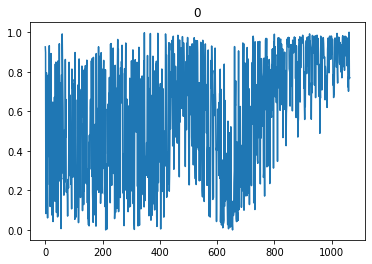

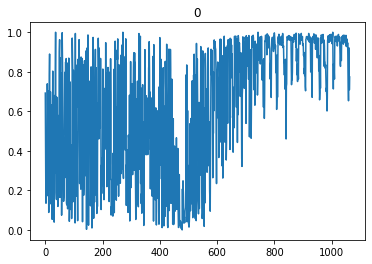

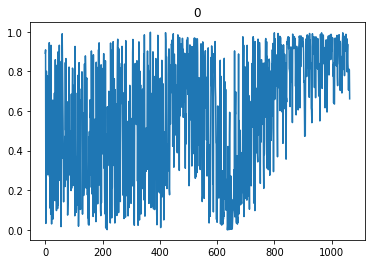

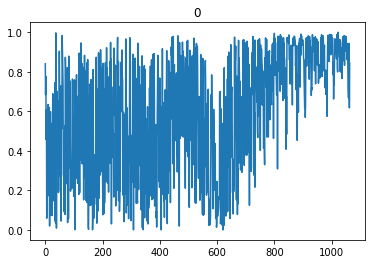

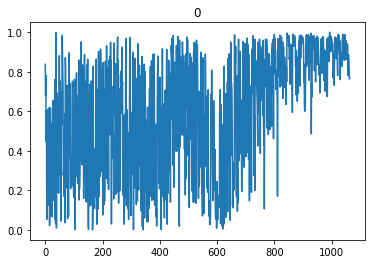

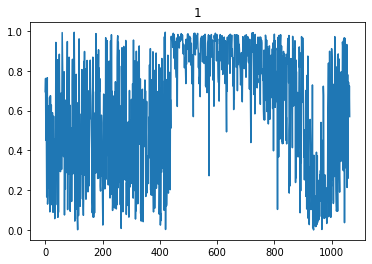

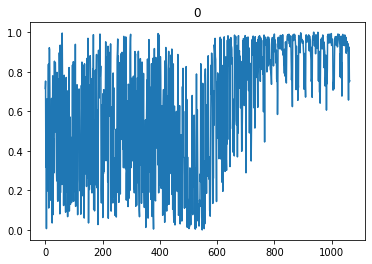

In [150]:
for i in range(10):
    plt.plot(X[_counts['index'].iloc[i]])
    plt.title('%s' % (y[_counts['index'].iloc[i]]))
    plt.show()
 

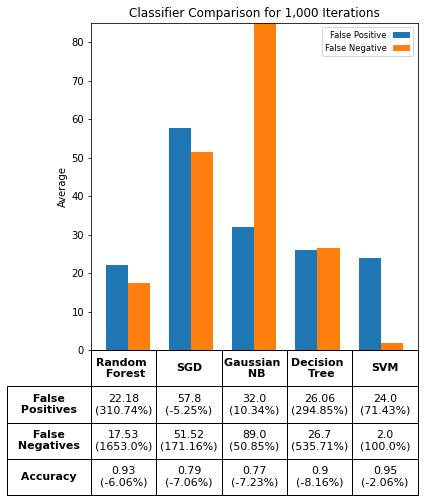

In [151]:
bar_plot_make(fn_data, fn_false_pos, fn_false_neg, fn_acc, data_prev=nn_data)

In [5]:
path_var = '/mnt/c/users/user/Desktop/norm_savgol_filter_lc/'

for filepath in glob.glob(path_var + '*.csv'):
        ts = pd.read_csv(filepath, delimiter=',', header=None)
        ts_ = [ts]
        

In [6]:
np.shape(ts_)

(1, 1001, 1)

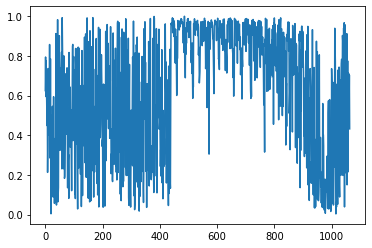

In [23]:
plt.plot(X[850])